# Kenali Sapinya
Anda memiliki 2 jenis gambar yaitu sapi tanpa background dan sapi dengan background.
Buatlah model pola sapi dengan gambar tanpa background. Kemudian gunakan pola tersebut untuk mendeteksi sapi dengan background. Gunakan interpolasi dan finite difference atau metode lain di dalam materi metode numerik.

Note:
1. Tidak boleh menggunakan library kecuali untuk membaca image
2. Algoritma Anda rancang sendiri dan implementasikan sendiri from scratch
3. Satu kelompok terdiri dari 4 orang.

In [20]:
import cv2
import matplotlib.pyplot as plt

## Menampilkan Gambar

In [21]:
def display_im(im1, im2, im3, title):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
  ax1.imshow(im1, cmap='gray')
  ax1.set_title('Sapi 1')
  ax2.imshow(im2, cmap='gray')
  ax2.set_title('Sapi 2')
  ax3.imshow(im3, cmap='gray')
  ax3.set_title('Sapi 3')
  f.suptitle(title, fontsize=15)

def display_im2(im1, im2, title):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.imshow(im1, cmap='gray')
  ax1.set_title('Sapi 1')
  ax2.imshow(im2, cmap='gray')
  ax2.set_title('Sapi 2')
  f.suptitle(title, fontsize=15)

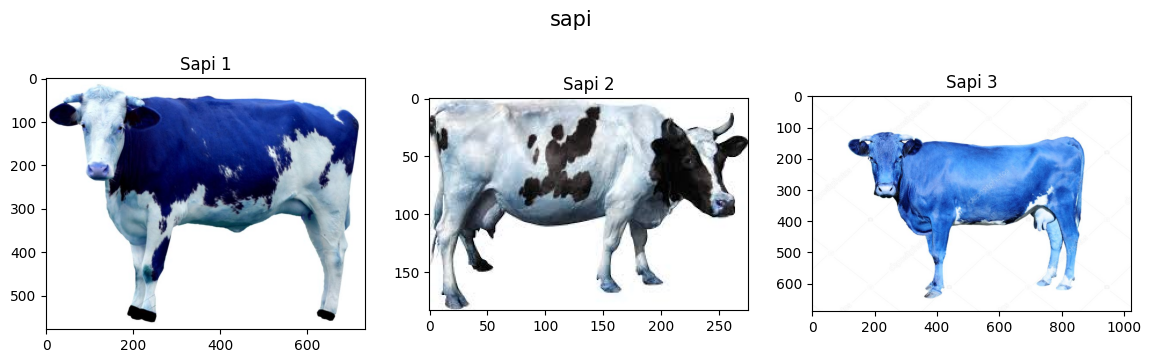

In [22]:
sapi_tanpa_bg1 = cv2.imread('./sapi1.jpg')
sapi_tanpa_bg2 = cv2.imread('./sapi2.jpeg')
sapi_tanpa_bg3 = cv2.imread('./sapi3.jpg')
display_im(sapi_tanpa_bg1,sapi_tanpa_bg2,sapi_tanpa_bg3, title='sapi')

In [23]:
image1 = sapi_tanpa_bg1
image2 = sapi_tanpa_bg2
image3 = sapi_tanpa_bg3

## Resize Image

In [24]:
def get_shape(image):
    height = len(image)
    width = len(image[0])
    return height, width

def resize_image(image, new_width, new_height):
    height, width = get_shape(image)

    scale_x = width / new_width
    scale_y = height / new_height

    resized_image = [[0] * new_width for _ in range(new_height)]

    for y in range(new_height):
        for x in range(new_width):
            src_x = int(x * scale_x)
            src_y = int(y * scale_y)

            x1 = src_x
            x2 = min(x1 + 1, width - 1)
            y1 = src_y
            y2 = min(y1 + 1, height - 1)

            weight_x = src_x - x1
            weight_y = src_y - y1

            top_left = image[y1][x1]
            top_right = image[y1][x2]
            bottom_left = image[y2][x1]
            bottom_right = image[y2][x2]

            interpolated_pixel = [
                int((1 - weight_x) * (1 - weight_y) * top_left[0] +
                    weight_x * (1 - weight_y) * top_right[0] +
                    (1 - weight_x) * weight_y * bottom_left[0] +
                    weight_x * weight_y * bottom_right[0]),
                int((1 - weight_x) * (1 - weight_y) * top_left[1] +
                    weight_x * (1 - weight_y) * top_right[1] +
                    (1 - weight_x) * weight_y * bottom_left[1] +
                    weight_x * weight_y * bottom_right[1]),
                int((1 - weight_x) * (1 - weight_y) * top_left[2] +
                    weight_x * (1 - weight_y) * top_right[2] +
                    (1 - weight_x) * weight_y * bottom_left[2] +
                    weight_x * weight_y * bottom_right[2])
            ]

            resized_image[y][x] = interpolated_pixel

    return resized_image

new_width = 200
new_height = 150

resized_image1 = resize_image(image1, new_width, new_height)
resized_image2 = resize_image(image2, new_width, new_height)
resized_image3 = resize_image(image3, new_width, new_height)

## Deteksi Edge dengan Finite Difference

In [25]:
def get_shape(image):
    # assumes that array is symmetric
    return len(image), len(image[0])

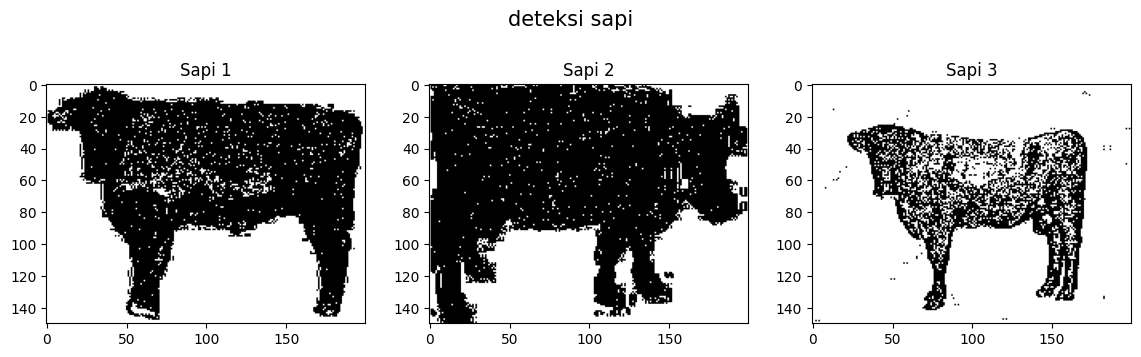

In [26]:
def calc_thresh(value, thresh):
    if value > thresh:
        return 0
    else:
        return 255

def calc_new_value(im, i, j, thresh):
    m, n = get_shape(im)
    h = 1

    if j == 0:
        a = im[i][j+1]  # Access the pixel value
        b = im[i][j+1]
        # forward
    elif j == n - 1:
        a = im[i][j-1]  # Access the pixel value
        b = im[i][j-1]
        # backward
    else:
        a = im[i][j+1]  # Access the pixel value
        b = im[i][j-1]
        h = 2

    return calc_thresh(abs(int(a[0]) - int(b[0])) / h, thresh)

def finite_diff(im, low_thresh, high_thresh):
    new_im = [row[:] for row in im]
    for i in range(len(im)):
        for j in range(len(im[i])):
            value = calc_new_value(im, i, j, high_thresh)
            if value == 0:
                new_im[i][j] = 0
            elif value == 255:
                new_im[i][j] = calc_new_value(im, i, j, low_thresh)
    return new_im

fdif_image1 = finite_diff(resized_image1, 0, 1)
fdif_image2 = finite_diff(resized_image2, 0, 1)
fdif_image3 = finite_diff(resized_image3, 6, 6)

display_im(fdif_image1, fdif_image2, fdif_image3, title='deteksi sapi')



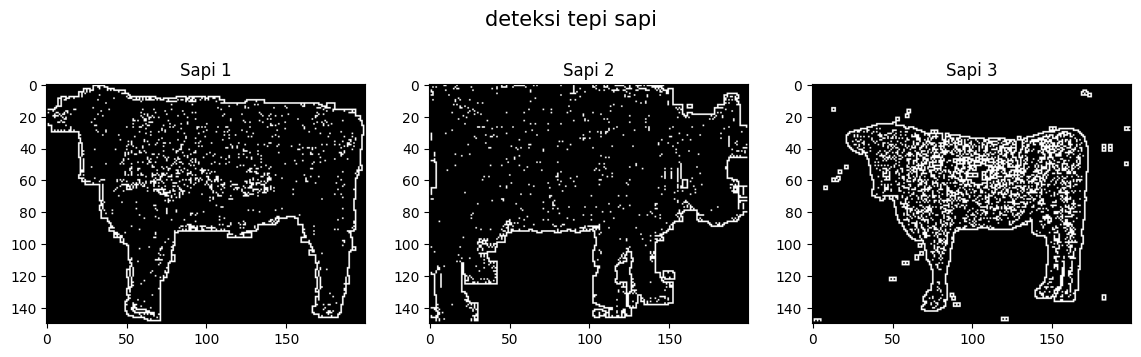

In [27]:
# 8-connectivity algorithm
def detect_edges(image):
    height, width = len(image), len(image[0])
    edges = [[0] * width for _ in range(height)]  # Initialize an empty edges image

    # Check the 8-connectivity of each pixel
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if image[i][j] == 255:  # Check if the pixel is filled
                if (
                    image[i - 1][j - 1] == 0
                    or image[i - 1][j] == 0
                    or image[i - 1][j + 1] == 0
                    or image[i][j - 1] == 0
                    or image[i][j + 1] == 0
                    or image[i + 1][j - 1] == 0
                    or image[i + 1][j] == 0
                    or image[i + 1][j + 1] == 0
                ):
                    edges[i][j] = 255  # Set the edge pixel to white

    return edges

detected_edges1 = detect_edges(fdif_image1)
detected_edges2 = detect_edges(fdif_image2)
detected_edges3 = detect_edges(fdif_image3)
display_im(detected_edges1, detected_edges2, detected_edges3, title='deteksi tepi sapi')

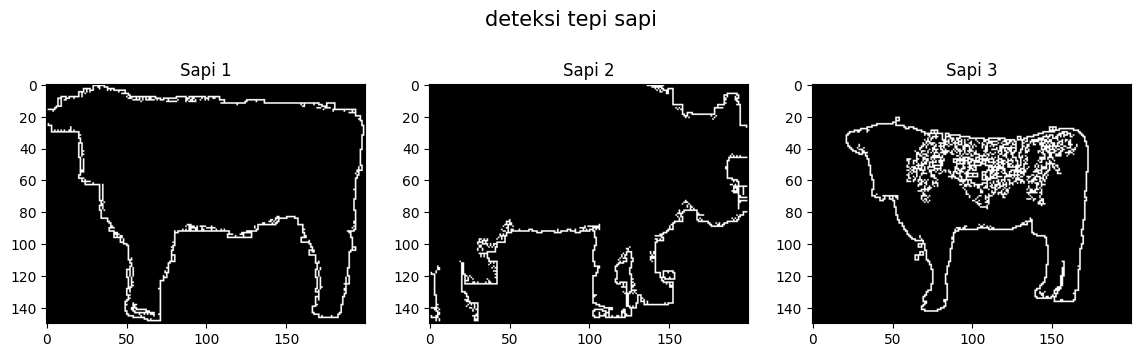

In [28]:
def connected_component_labeling(edges):
    height, width = len(edges), len(edges[0])
    visited = [[False] * width for _ in range(height)]
    components = []

    def dfs(i, j, component):
        if i < 0 or i >= height or j < 0 or j >= width:
            return
        if visited[i][j] or edges[i][j] != 255:
            return

        visited[i][j] = True
        component.append((i, j))

        # Explore the 8-connectivity neighbors
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                dfs(i + dx, j + dy, component)

    # Perform connected component labeling
    for i in range(height):
        for j in range(width):
            if not visited[i][j] and edges[i][j] == 255:
                component = []
                dfs(i, j, component)
                components.append(component)

    return components


def remove_disconnected_dots(edges, min_dot_size):
    components = connected_component_labeling(edges)

    # Remove small disconnected dots
    for component in components:
        if len(component) < min_dot_size:
            for i, j in component:
                edges[i][j] = 0

    return edges

undisconnected_dots1 = remove_disconnected_dots(detected_edges1, 40)
undisconnected_dots2 = remove_disconnected_dots(detected_edges2, 40)
undisconnected_dots3 = remove_disconnected_dots(detected_edges3, min_dot_size=125)
display_im(undisconnected_dots1, undisconnected_dots2, undisconnected_dots3, title='deteksi tepi sapi')

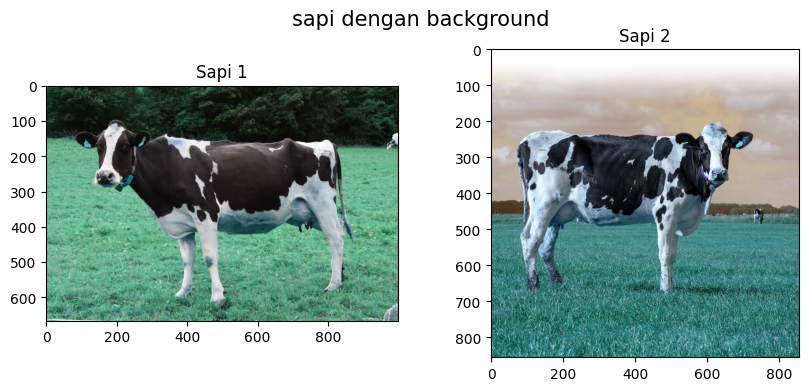

In [29]:
sapi_dgn_bg1 = cv2.imread('./sapi_x.jpeg')
sapi_dgn_bg2 = cv2.imread('./sapiy.jpg')

display_im2(sapi_dgn_bg1, sapi_dgn_bg2, title='sapi dengan background')

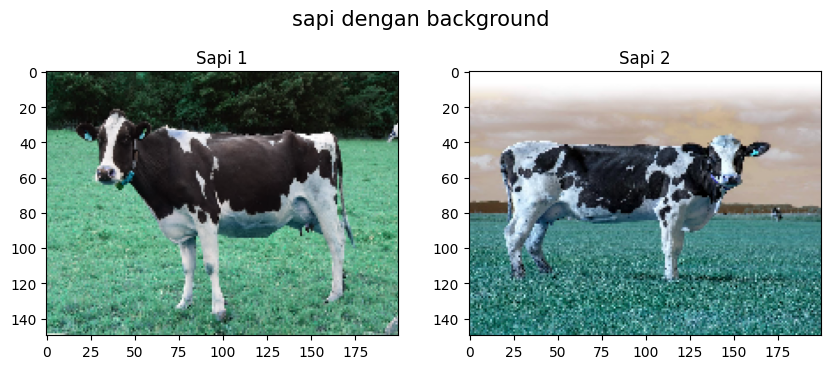

In [30]:
resized_image4 = resize_image(sapi_dgn_bg1, new_width, new_height)
resized_image5 = resize_image(sapi_dgn_bg2, new_width, new_height)

display_im2(resized_image4, resized_image5, title='sapi dengan background')

In [31]:
pattern = undisconnected_dots1
pattern2 = undisconnected_dots2
pattern3 = undisconnected_dots3

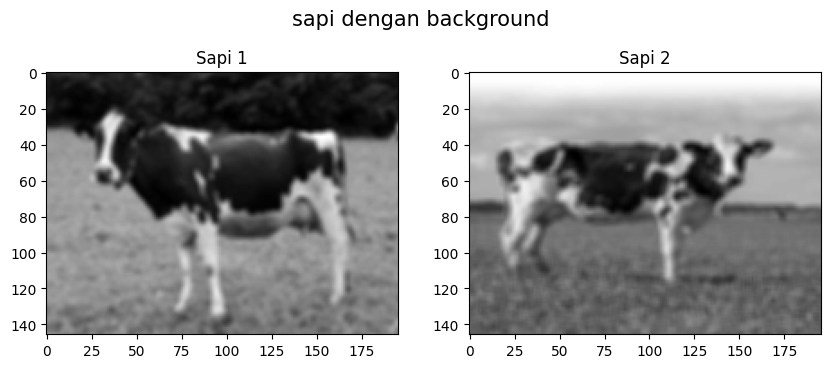

In [32]:
def gaussian_blur(image, kernel_size, sigma):
    # Convert the image to grayscale
    gray_image = []
    for row in image:
        gray_row = []
        for pixel in row:
            gray_value = int(pixel[0] * 0.299 + pixel[1] * 0.587 + pixel[2] * 0.114)
            gray_row.append(gray_value)
        gray_image.append(gray_row)

    # Apply Gaussian blur for noise reduction
    blurred_image = []
    padding = kernel_size // 2

    for i in range(padding, len(gray_image) - padding):
        blurred_row = []
        for j in range(padding, len(gray_image[i]) - padding):
            pixel_value = 0
            for x in range(-padding, padding + 1):
                for y in range(-padding, padding + 1):
                    exponent = -0.5 * ((x**2 + y**2) / (sigma**2))
                    factor = 1.0  # Set factor to 1 as an alternative to using exp function
                    for _ in range(int(abs(exponent) * 100)):  # Manual approximation of exponentiation
                        factor *= 0.99  # Adjust the factor value for more accurate approximation
                    pixel_value += gray_image[i + x][j + y] * factor

            blurred_row.append(pixel_value // (kernel_size**2))
        blurred_image.append(blurred_row)

    return blurred_image

# Example usage
blurred_image1 = gaussian_blur(resized_image4, kernel_size=5, sigma=1.5)
blurred_image2 = gaussian_blur(resized_image5, kernel_size=5, sigma=2.0)

# Adjust intensity levels
def normalized(image):
    max_value = max(max(image))
    min_value = min(min(image))
    normalized_image = []
    for row in image:
        normalized_row = []
        for pixel_value in row:
            normalized_value = int(255 * (pixel_value - min_value) / (max_value - min_value))
            normalized_row.append(normalized_value)
        normalized_image.append(normalized_row)

    return normalized_image


normalized_image1 = normalized(blurred_image1)
normalized_image2 = normalized(blurred_image2)

display_im2(normalized_image1, normalized_image2, title='sapi dengan background')

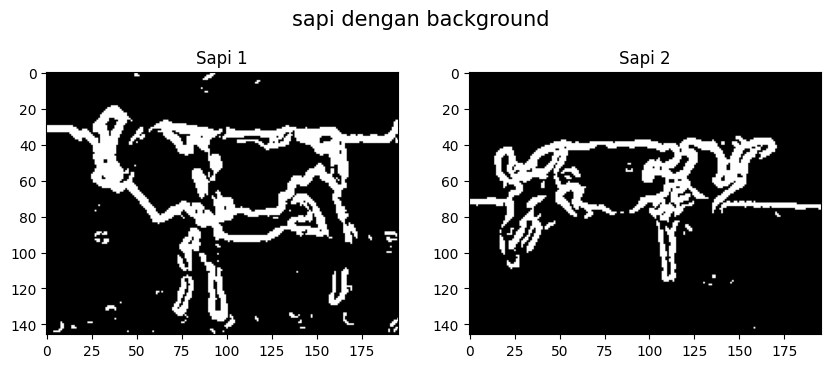

In [143]:
def graph_cut_segmentation(image, threshold):
    # Create graph from the image
    height = len(image)
    width = len(image[0])
    graph = [[0] * width for _ in range(height)]

    # Set the weights of the graph edges
    for y in range(height):
        for x in range(width):
            pixel_value = image[y][x]

            # Set the weight of the edge connecting adjacent pixels
            if x > 0:
                weight = abs(pixel_value - image[y][x - 1])
                graph[y][x] += weight
                graph[y][x - 1] += weight
            if y > 0:
                weight = abs(pixel_value - image[y - 1][x])
                graph[y][x] += weight
                graph[y - 1][x] += weight

    # Perform graph cut
    segmented_image = [[0] * width for _ in range(height)]
    for y in range(height):
        for x in range(width):
            if graph[y][x] > threshold:
                segmented_image[y][x] = 1  # Object
            else:
                segmented_image[y][x] = 0  # Background

    return segmented_image

graph_cut_segmentation1 = graph_cut_segmentation(normalized_image1, 40)
graph_cut_segmentation2 = graph_cut_segmentation(normalized_image2, 40)
display_im2(graph_cut_segmentation1, graph_cut_segmentation2, title='sapi dengan background')


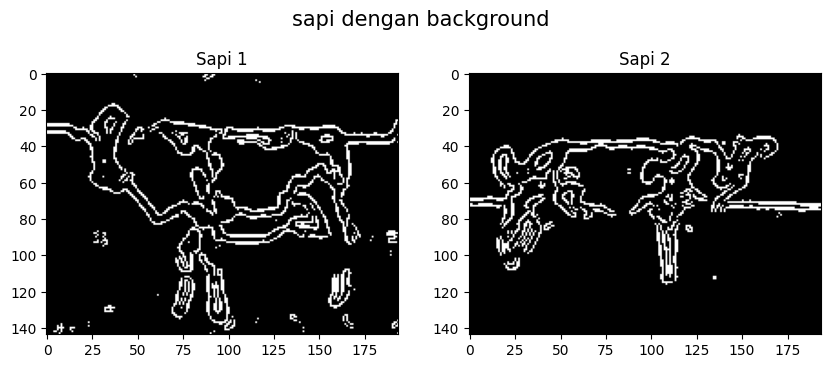

In [163]:
# Perform Sobel filtering for edge detection
def canny_edges_detection(image):
    gradient_x = []
    gradient_y = []
    sobel_threshold = 4 #
    # Adjust the threshold value as needed

    for i in range(1, len(image) - 1):
        gradient_row_x = []
        gradient_row_y = []
        for j in range(1, len(image[i]) - 1):
            gx = (image[i + 1][j - 1] + 2 * image[i + 1][j] + image[i + 1][j + 1]) - \
                (image[i - 1][j - 1] + 2 * image[i - 1][j] + image[i - 1][j + 1])
            gy = (image[i - 1][j + 1] + 2 * image[i][j + 1] + image[i + 1][j + 1]) - \
                (image[i - 1][j - 1] + 2 * image[i][j - 1] + image[i + 1][j - 1])
            gradient_row_x.append(gx)
            gradient_row_y.append(gy)
        gradient_x.append(gradient_row_x)
        gradient_y.append(gradient_row_y)

    # Calculate edge magnitude
    edge_magnitude = []
    for i in range(len(gradient_x)):
        magnitude_row = []
        for j in range(len(gradient_x[i])):
            magnitude = (gradient_x[i][j]**2 + gradient_y[i][j]**2) ** 0.5
            magnitude_row.append(magnitude)
        edge_magnitude.append(magnitude_row)

    # Apply thresholding to extract strong edges
    canny_edges = []
    for i in range(len(edge_magnitude)):
        edges_row = []
        for j in range(len(edge_magnitude[i])):
            if edge_magnitude[i][j] >= sobel_threshold:
                edges_row.append(255)
            else:
                edges_row.append(0)
        canny_edges.append(edges_row)

    return canny_edges

# Display the edges
canny_edges1 = canny_edges_detection(graph_cut_segmentation1)
canny_edges2 = canny_edges_detection(graph_cut_segmentation2)

display_im2(canny_edges1, canny_edges2, title='sapi dengan background')